In [1]:
import pandas as pd
import geopandas as gp 
import json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gp
sns.set(rc={'figure.figsize':(12,8)})
%matplotlib inline
from tqdm import tqdm
import glob
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import linregress
import pickle as pkl

In [2]:
files = glob.glob('../BL_Work/openPrescribe/savings/*.h5')
files.sort()
print files

['../BL_Work/openPrescribe/savings/201008.h5', '../BL_Work/openPrescribe/savings/201009.h5', '../BL_Work/openPrescribe/savings/201010.h5', '../BL_Work/openPrescribe/savings/201011.h5', '../BL_Work/openPrescribe/savings/201012.h5', '../BL_Work/openPrescribe/savings/201101.h5', '../BL_Work/openPrescribe/savings/201102.h5', '../BL_Work/openPrescribe/savings/201103.h5', '../BL_Work/openPrescribe/savings/201104.h5', '../BL_Work/openPrescribe/savings/201105.h5', '../BL_Work/openPrescribe/savings/201106.h5', '../BL_Work/openPrescribe/savings/201107.h5', '../BL_Work/openPrescribe/savings/201108.h5', '../BL_Work/openPrescribe/savings/201109.h5', '../BL_Work/openPrescribe/savings/201110.h5', '../BL_Work/openPrescribe/savings/201111.h5', '../BL_Work/openPrescribe/savings/201112.h5', '../BL_Work/openPrescribe/savings/201201.h5', '../BL_Work/openPrescribe/savings/201202.h5', '../BL_Work/openPrescribe/savings/201203.h5', '../BL_Work/openPrescribe/savings/201204.h5', '../BL_Work/openPrescribe/savings

In [3]:
pdp = pd.read_hdf(files[0])

In [4]:
# %store -r opiod_BNF
%store -r antiDM_BNF
%store -r opiod_BNF
%store -r antiDep_BNF

In [7]:
len(opiod_BNF)

59

In [10]:
LSOA_dist = json.load(open('scratchpad/GP_LSOA_PATIENTSDIST.json','rb'))

In [11]:
opiod_BNF.head()

,Unnamed: 0,BNF_code,NAME,UNII_drugbank
88,88,0104020D0,Codeine Phosphate Compound Mixtures ...,UX6OWY2V7J
90,90,0104020L0,Loperamide Hydrochloride ...,6X9OC3H4II
91,91,0104020N0,Opium & Morphine ...,76I7G6D29C
92,92,0104020P0,Loperamide Hydrochloride & Simeticone ...,6X9OC3H4II
154,154,0106060A0,Methylnaltrexone Bromide ...,0RK7M7IABE


In [13]:
ward_pop = pd.read_csv('scratchpad/ward_pop.csv')

/home/sagar/anaconda3/envs/env_py2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (23,24,25,26,27,28,29,30,31,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
GP_META = pd.read_csv('../BL_Work/epraccur.csv',header=None)
GP_META.rename(columns={0:'BP_code',
                        1:'Name',
                        2:'Grouping',
                        3:'National_geo',
                        4:'Addr1',
                        5:'Addr2',
                        6:'Addr3',
                        7: 'Addr4',
                        8:'Addr5',
                        9:'Postcode',
                        10:'Open',
                        11:'Closed',
                        12:'Status',
                        13:'Org type code',
                        14:'Commissioner',
                        15:'Join provider',
                        16:'Left provider',
                        17:'Contact',
                        18:'Null1',
                        19:'Null2',
                        20:'Null3',
                        21:'Amended',
                        22:'Null4',
                        23:'Provider',
                        24:'Null5',
                        25:'Setting',
                        26:'Null6'}, 
                 inplace=True)

In [15]:
Open_filtered_GPs = {}
for index,row in GP_META.iterrows():
    if row ['Setting'] == 4 and row['Status'] =='A':
        Open_filtered_GPs[row['BP_code']] = row['Postcode'].strip()

In [16]:
population = {}
for index, row in ward_pop.iterrows():
    population[row['Ward Code 1']] = float(row['All Ages'].replace(',',''))

In [17]:
population_borough = {}
for name,group in ward_pop.groupby('Local Authority'):
    population_borough[name] = 0.0
    for index , row in group.iterrows():
        population_borough[name] += float(row['All Ages'].replace(',',''))

In [18]:
pdp.head()

Unnamed: 0    0    1       2                3  \
0 8327         9404  Q30  5D7  A86011  0101010C0AAAAAA   
  35930       38180  Q30  5D7  A86040  0101010C0BBAAAA   
  60856       65924  Q30  5D8  A87016  0101010C0AAAAAA   
  64926       69994  Q30  5D8  A87020  0101010C0AAAAAA   
  69494       74562  Q30  5D8  A87029  0101010C0BBAAAA   

                                                4    5     6     7      8  \
0 8327   Alum Hydrox_Cap 475mg                     1.0  5.81  5.38  186.0   
  35930  Alu-Cap_Cap 475mg                         2.0  7.50  6.97  240.0   
  60856  Alum Hydrox_Cap 475mg                     1.0  5.25  4.86  168.0   
  64926  Alum Hydrox_Cap 475mg                     1.0  3.75  3.48  120.0   
  69494  Alu-Cap_Cap 475mg                         1.0  3.75  3.48  120.0   

         ...                   14     15         16    17   18    19  20  \
0 8327   ...  Aluminium Hydroxide  475.0  0101010C0   9.3  1.0   9.3  AA   
  35930  ...  Aluminium Hydroxide  475.0  0101010C0  12.0  1.0  12.0  BB   
  60856  ...  Aluminium Hydroxide  475.0  0101010C0   8.4  1.0   8.4  AA   
  64926  ...  Aluminium Hydroxide  475.0  0101010C0   6.0  1.0   6.0  AA   
  69494  ...  Aluminium Hydroxide  475.0  0101010C0   6.0  1.0   6.0  BB   

           21      22     23  
0 8327   0.03  0.0305  0.093  
  35930  0.03  0.0305  0.120  
  60856  0.03  0.0305  0.084  
  64926  0.03  0.0305  0.060  
  69494  0.03  0.0305  0.060  

[5 rows x 25 columns]

In [19]:
rantadine = pdp.loc[pdp['16'] == '0601023B0']

In [20]:
rantadine.head()

Unnamed: 0    0    1       2                3  \
751 1022        1022  Q30  5D7  A86003  0601023B0AAAAAA   
    1023        1023  Q30  5D7  A86003  0601023B0AAABAB   
    1024        1024  Q30  5D7  A86003  0601023B0AAACAC   
    2833        2833  Q30  5D7  A86004  0601023B0AAAAAA   
    2834        2834  Q30  5D7  A86004  0601023B0AAABAB   

                                                 4     5        6        7  \
751 1022  Pioglitazone HCl_Tab 15mg                  9.0   180.82   166.68   
    1023  Pioglitazone HCl_Tab 30mg                 28.0  1112.56  1024.68   
    1024  Pioglitazone HCl_Tab 45mg                  3.0   118.65   109.29   
    2833  Pioglitazone HCl_Tab 15mg                  2.0    51.66    47.60   
    2834  Pioglitazone HCl_Tab 30mg                 16.0   825.47   760.11   

              8  ...   14    15         16     17   18     19  20        21  \
751 1022  196.0  ...  NaN  15.0  0601023B0   49.0  1.0   49.0  AA  0.854286   
    1023  868.0  ...  NaN  30.0  0601023B0  217.0  2.0  434.0  AA  1.184286   
    1024   84.0  ...  NaN  45.0  0601023B0   21.0  3.0   63.0  AA  1.304286   
    2833   56.0  ...  NaN  15.0  0601023B0   14.0  1.0   14.0  AA  0.854286   
    2834  644.0  ...  NaN  30.0  0601023B0  161.0  2.0  322.0  AA  1.184286   

                22    23  
751 1022  0.848929  0.00  
    1023  1.187500  2.79  
    1024  1.304762  0.04  
    2833  0.848929  0.00  
    2834  1.187500  2.07  

[5 rows x 25 columns]

In [21]:
min(rantadine['15'])

15.0

In [22]:
opioids = pdp.loc[pdp['16'].isin(opiod_BNF['BNF_code'])]
# opioids = pdp

In [23]:
non_generic_opioid = opioids.loc[opioids['20']!='AA']

In [24]:
sum(non_generic_opioid['23'])

303319.84835714626

In [25]:
sum(opioids['7'])

19498899.660013113

In [26]:
len(non_generic_opioid), len(opioids)

(82520, 288518)

In [27]:
GP_postcodes_long = {}
for name , group in non_generic_opioid.groupby('2'):
    postcode = list(set(group['10']))
    GP_postcodes_long[name] = str(postcode[0]).strip()

In [28]:
ward_df = pd.read_csv('../BL_Work/pcd11_par11_wd11_lad11_ew_lu.csv')

# ward_df.head()

ward_postcode_map = {}
for name, group in ward_df.groupby('wd11cd'):
    ward_postcode_map[name] = list(group['pcds'])

/home/sagar/anaconda3/envs/env_py2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (5,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
LSOA_savings = {}

for name, group in tqdm(non_generic_opioid.groupby('2')):
    total_saving = np.sum(group['23'])
    if name in LSOA_dist:        
        for k in LSOA_dist[name]:
            if k not in LSOA_savings:
                LSOA_savings[k] = 0.0
            LSOA_savings[k]+= float(total_saving)*float(LSOA_dist[name][k])

100%|██████████| 6646/6646 [00:04<00:00, 1430.10it/s]


In [30]:
%store -r Ward_prevalence
%store -r Ward_patients
%store -r DiseasePop_byWard

In [31]:
df = pd.read_csv('../BL_Work/Lower_Layer_Super_Output_Area_2011_to_Ward_2015_Lookup_in_England_and_Wales.csv')

In [32]:
wardMap = {}
for name , group in df.groupby('WD15CD'):
        wardMap[name] = list(group['LSOA11CD'])

In [33]:
boroughMap = {}
for name , group in df.groupby('LAD15NM'):
        boroughMap[name] = list(group['LSOA11CD'])

In [34]:
population_borough = {}
for name,group in ward_pop.groupby('Local Authority'):
    population_borough[name] = 0.0
    for index , row in group.iterrows():
        population_borough[name] += float(row['All Ages'].replace(',',''))

In [35]:
borough_savings_UK = {}

for k in boroughMap:
    try:
        borough_savings= np.sum([LSOA_savings[w] for w in boroughMap[k] if not np.isnan(LSOA_savings[w])])
        pop = population_borough[k]
        borough_savings_UK[k] = (float(borough_savings)/float(pop))*1000.0
        
    except:
        print "Some ward had wrong data"

Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data


In [36]:
borough_savings_UK

{'Adur': 6.436231401983831,
 'Allerdale': 3.378537411920643,
 'Amber Valley': 2.0412491565585573,
 'Arun': 5.3171451681874276,
 'Ashfield': 3.2369200163395475,
 'Ashford': 11.639270018491231,
 'Aylesbury Vale': 2.866005436645724,
 'Babergh': 18.757198665227577,
 'Barking and Dagenham': 4.607189852922233,
 'Barnet': 1.5381755933506325,
 'Barnsley': 5.278377122799099,
 'Barrow-in-Furness': 6.3404539733738385,
 'Basildon': 3.1117641988317954,
 'Basingstoke and Deane': 3.314988747580268,
 'Bassetlaw': 5.288226117328803,
 'Bath and North East Somerset': 3.5080112335084546,
 'Bedford': 6.471467965638308,
 'Bexley': 8.594393008349648,
 'Birmingham': 4.100487856080527,
 'Blaby': 7.989305020070649,
 'Blackburn with Darwen': 3.9793273548690093,
 'Blackpool': 7.819852109417434,
 'Bolsover': 2.736299772681294,
 'Bolton': 5.847322610125084,
 'Boston': 12.607761208932747,
 'Bournemouth': 1.1620771376257142,
 'Bracknell Forest': 6.788472969531297,
 'Bradford': 3.503486780096818,
 'Braintree': 9.79743

In [37]:
%store -r cityMap 
%store -r cityPop

In [299]:
# cityMap

In [38]:
len(cityPop)

109

In [200]:
def calculateTemporalMetrics(all_presc, non_generic,  population_borough):
    LSOA_savings = {}
    LSOA_dosage = {}
    LSOA_costs = {}
    fail = 0.0
    for name, group in all_presc.groupby('2'):
        total_dosage = np.sum(group['19'])
        total_cost = np.sum(group['7'])
        if name in LSOA_dist:        
            for k in LSOA_dist[name]:
                if k not in LSOA_dosage:
                    LSOA_dosage[k] = 0.0
                    LSOA_costs[k] = 0.0
                LSOA_dosage[k]+= float(total_dosage)*float(LSOA_dist[name][k])
                LSOA_costs[k]+= float(total_cost)*float(LSOA_dist[name][k])

    for name, group in non_generic.groupby('2'):
        total_saving = np.sum(group['23'])
        if name in LSOA_dist:        
            for k in LSOA_dist[name]:
                if k not in LSOA_savings:
                    LSOA_savings[k] = 0.0
                LSOA_savings[k]+= float(total_saving)*float(LSOA_dist[name][k])

    borough_savings_UK = {}
    borough_dosage_UK = {}
    borough_cost_UK = {}
#     for k in boroughMap:
#         try:
#             borough_savings= np.sum([LSOA_savings[w] for w in boroughMap[k] if not np.isnan(LSOA_savings[w])])
#             borough_dosages= np.sum([LSOA_dosage[w] for w in boroughMap[k] if not np.isnan(LSOA_dosage[w])])
#             borough_costs= np.sum([LSOA_costs[w] for w in boroughMap[k] if not np.isnan(LSOA_costs[w])])

#             pop = population_borough[k]
#             borough_savings_UK[k] = float(borough_savings)
#             borough_dosage_UK[k] = (float(borough_dosages)/float(pop))*1000.0
#             borough_cost_UK[k] = (float(borough_costs)/float(pop))*1000.0

#         except:
#             fail+=1

#calculate city level savings
    for k in cityMap:
        try:
            borough_savings= np.sum([LSOA_savings[w] for w in cityMap[k] if not np.isnan(LSOA_savings[w])])
            borough_dosages= np.sum([LSOA_dosage[w] for w in cityMap[k] if not np.isnan(LSOA_dosage[w])])
            borough_costs= np.sum([LSOA_costs[w] for w in cityMap[k] if not np.isnan(LSOA_costs[w])])

            pop = cityPop[k]
            borough_savings_UK[k] = float(borough_savings)
            borough_dosage_UK[k] = float(borough_dosages)
            borough_cost_UK[k] = (float(borough_costs)/float(pop))*1000.0

        except:
            fail+=1
    
    return borough_savings_UK , borough_dosage_UK , borough_cost_UK

In [201]:
%store -r category_BNF_map

In [202]:
category_BNF_map['Antibacterials for Systemic Use']

['0501110N0',
 '0501070U0',
 '1103010Z0',
 '0501030B0',
 '1103010D0',
 '1310012C0',
 '050102020',
 '0501050B0',
 '0501012U0',
 '0501120Y0',
 '0501040C0',
 '0501040D0',
 '1103010AA',
 '0501015P0',
 '0501120R0',
 '0501013E0',
 '0501014N0',
 '0501014P0',
 '0501014R0',
 '0501070R0',
 '0501120P0',
 '1103010Y0',
 '1201010AB',
 '0501060D0',
 '0501060E0',
 '0702020E0',
 '1306010D0',
 '1306010E0',
 '1306010F0',
 '0501011K0',
 '0501050S0',
 '0501020G0',
 '0501020J0',
 '0501130E0',
 '0501130H0',
 '0501130K0',
 '1312000K0',
 '0501014C0',
 '0501120V0',
 '0501021G0',
 '0501020N0',
 '0704040H0',
 '0501013V0',
 '0501120K0',
 '0501120L0',
 '1103010B0',
 '1201010AC',
 '1201020Q0',
 '0501080V0',
 '0501040N0',
 '1103010N0',
 '1201010T0',
 '1202010N0',
 '1202030S0',
 '1310011P0',
 '0501013B0',
 '0501013C0',
 '0501020T0',
 '1103010AK',
 '0501120W0',
 '0501080I0',
 '0501020V0',
 '110301030',
 '0501040K0',
 '0501013T0',
 '0501013U0',
 '0501013W0',
 '0501021J0',
 '0501021K0',
 '1103010T0',
 '0501022B0',
 '0501

In [203]:
category_BNF_map.keys()

[u'Posterior Pituitary Lobe Hormones',
 u'Curare Alkaloids',
 u'Breast Cancer Resistance Protein Inhibitors',
 u'Prostacyclin Analogues',
 u'UGT1A1 Substrates',
 u'Lactates',
 u'Caffeine',
 u'BCRP/ABCG2 Inhibitors',
 u'Cytochrome P-450 CYP2B6 Inhibitors (strength unknown)',
 u'Sucrose-specific Enzyme',
 u'Deoxycytidine',
 u'Histamine H2 Antagonists',
 u'Vitamins',
 u'Thiazide-like Diuretic',
 u'HIV Antigens',
 u'Microtubule Inhibition',
 u'Arsenicals',
 u'Phosphinic Acids',
 u'Acyclovir',
 u'Hydroxyquinolines',
 u'Cytochrome P450 3A4 Inhibitors',
 u'Vinca Alkaloids',
 u'OCT1 substrates',
 u'Insecticides and Repellents',
 u'Phosphoramide Mustards',
 u'Decreased Protein Synthesis',
 u'OAT3/SLC22A8 Substrates',
 u'Cytochrome P-450 CYP3A Inhibitors (strong)',
 u'Lipopeptide Antibacterial',
 u'Nitrofuran Derivatives',
 u'Antibiotics, Antitubercular',
 u'Heroin, agonists',
 u'Protein-Lysine 6-Oxidase, antagonists & inhibitors',
 u'Growth Inhibitors',
 u'Insulin, Short-Acting',
 u'Erythropoie

In [204]:
# selectedKeys = ['Vitamins','Histamine H2 Antagonists','Heroin, agonists','Anemia, Iron-Deficiency','Lipids','Dopamine Agents'
#                 ,'Alcohol Deterrents','Nicotine, antagonists & inhibitors','Anti-Obesity Agents','Antibacterials for Systemic Use']
selectedKeys = ['opioids']

In [205]:
sorted_category = sorted(category_BNF_map.items(), key=lambda item: len(item[1]),reverse=True)

In [206]:
# sorted_category[30:40]

In [207]:
# monthly_borough_savings = {k : {} for k in selectedKeys}
# monthly_borough_dosage = {k : {} for k in selectedKeys}
# monthly_borough_costs = {k : {} for k in selectedKeys}

In [208]:
# monthly_borough_savings = {'opioids':{},'dep':{},'diabetes':{}}
# monthly_borough_dosage = {'opioids':{},'dep':{},'diabetes':{}}
# monthly_borough_costs = {'opioids':{},'dep':{},'diabetes':{}}


monthly_borough_savings = {'opioids':{}}
monthly_borough_dosage = {'opioids':{}}
monthly_borough_costs = {'opioids':{}}

In [209]:
pdp = pd.read_hdf(files[15])

In [210]:
# for f in tqdm(files[17:29]):
# # for f in tqdm(files):
#     month = f.split('/')[-1].split('.')[0]
#     monthly_borough_savings[month] = {}
#     pdp = pd.read_hdf(f)
    
#     for k in selectedKeys:
#         df_k = pdp.loc[pdp['16'].isin(category_BNF_map[k])]
#         non_generic_k = df_k.loc[df_k['20']!='AA']
#         monthly_borough_savings[k][month], monthly_borough_dosage[k][month] ,monthly_borough_costs[k][month] = calculateTemporalMetrics(df_k , non_generic_k , population_borough)

In [211]:
# pkl.dump(monthly_borough_savings,open('10_Cat_savings.pkl','wb'))

# pkl.dump(monthly_borough_dosage,open('10_Cat_dosage.pkl','wb'))

# pkl.dump(monthly_borough_costs,open('10_Cat_costs.pkl','wb'))

In [212]:

# for f in tqdm(files):
for f in tqdm(files[65:77]):
    month = f.split('/')[-1].split('.')[0]
    monthly_borough_savings[month] = {}
    pdp = pd.read_hdf(f)
    opioids = pdp.loc[pdp['16'].isin(opiod_BNF['BNF_code'])]
#     anti_dm = pdp.loc[pdp['16'].isin(antiDM_BNF['BNF_code'])]
#     anti_dep = pdp.loc[pdp['16'].isin(antiDep_BNF['BNF_code'])]
    
    non_generic_opioid = opioids.loc[opioids['20']!='AA']
#     non_generic_dm = anti_dm.loc[anti_dm['20']!='AA']
#     non_generic_dep = anti_dep.loc[anti_dep['20']!='AA']

    monthly_borough_savings['opioids'][month], monthly_borough_dosage['opioids'][month] ,monthly_borough_costs['opioids'][month] = calculateTemporalMetrics(opioids , non_generic_opioid , population_borough)
#     monthly_borough_savings['diabetes'][month], monthly_borough_dosage['diabetes'][month] ,monthly_borough_costs['diabetes'][month] = calculateTemporalMetrics(anti_dm , non_generic_dm , population_borough)
#     monthly_borough_savings['dep'][month], monthly_borough_dosage['dep'][month] ,monthly_borough_costs['dep'][month] = calculateTemporalMetrics(anti_dep , non_generic_dep , population_borough)



100%|██████████| 12/12 [07:19<00:00, 37.36s/it]

In [134]:
IMD_df = pd.read_csv('../BL_Work/File_7_ID_2015_All_ranks__deciles_and_scores_for_the_Indices_of_Deprivation__and_population_denominators.csv')

In [213]:
# IMD_df.head()

In [214]:
IMD_city = {}
for k in cityMap:
    city_LSOA_IMD = IMD_df[IMD_df['LSOA code (2011)'].isin(cityMap[k])]
    medianIMD_city = np.median(city_LSOA_IMD['Index of Multiple Deprivation (IMD) Score'])
    IMD_city[k] = medianIMD_city
# IMD_city

In [215]:
cityMap

{'Barnsley': ['E01007344',
  'E01007355',
  'E01007356',
  'E01007357',
  'E01007358',
  'E01007359',
  'E01007360',
  'E01007361',
  'E01007362',
  'E01007363',
  'E01007379',
  'E01007380',
  'E01007381',
  'E01007386',
  'E01007387',
  'E01007317',
  'E01007318',
  'E01007319',
  'E01007320',
  'E01007321',
  'E01007322',
  'E01007323',
  'E01007324',
  'E01007325',
  'E01007326',
  'E01007327',
  'E01007334',
  'E01007335',
  'E01007336',
  'E01007337',
  'E01007338',
  'E01007339',
  'E01007340',
  'E01007446',
  'E01007400',
  'E01007402',
  'E01007403',
  'E01007404',
  'E01007405',
  'E01007406',
  'E01007408',
  'E01007409',
  'E01007410',
  'E01007411',
  'E01007413',
  'E01007414',
  'E01007415',
  'E01007416',
  'E01007417',
  'E01007437',
  'E01007441',
  'E01007442',
  'E01007443',
  'E01007444',
  'E01007445',
  'E01032550',
  'E01032551'],
 'Basildon': ['E01021323',
  'E01021324',
  'E01021325',
  'E01021326',
  'E01021327',
  'E01021273',
  'E01021328',
  'E01021274',


In [216]:
%store IMD_city

Stored 'IMD_city' (dict)


In [217]:
len(IMD_city)

112

In [301]:
# json.dump(cityPop,open('City_pop_england.json','w'))

In [218]:
# %store monthly_borough_savings
# %store monthly_borough_dosage
# %store monthly_borough_costs

In [219]:
# pkl.dump(monthly_borough_savings,open('the_three_city_savings.pkl','wb'))

# pkl.dump(monthly_borough_dosage,open('the_three_city_dosage.pkl','wb'))

# pkl.dump(monthly_borough_costs,open('the_three_city_costs.pkl','wb'))

In [220]:
# pkl.dump(monthly_borough_savings,open('the_three_savings.pkl','wb'))

# pkl.dump(monthly_borough_dosage,open('the_three_dosage.pkl','wb'))

# pkl.dump(monthly_borough_costs,open('the_three_costs.pkl','wb'))

In [221]:
# monthly_borough_savings = pkl.load(open('10_Cat_savings.pkl','rb'))

# monthly_borough_dosage  = pkl.load(open('the_three_dosage.pkl','rb'))

# monthly_borough_costs = pkl.load(open('the_three_costs.pkl','rb'))

In [223]:
# len(monthly_borough_savings['opioids']['201201'])

In [224]:
total_savings = {k:0 for k in selectedKeys}
for k in total_savings.keys():
    disease_saving= monthly_borough_savings[k]
    for month in disease_saving:
        total_savings[k]+= np.sum(disease_saving[month].values())
    
print total_savings

{'opioids': 8160565.395357025}


In [225]:
import operator
sorted(total_savings.items(), key=operator.itemgetter(1))

[('opioids', 8160565.395357025)]

In [226]:
# sorted(monthly_borough_savings['Vitamins'].keys())

In [227]:
disease = 'opioids'
cityOverSpending = {}
savings = monthly_borough_savings[disease]
for k in savings:
    for city in savings[k]:
        if city not in cityOverSpending:
            cityOverSpending[city] = 0
        else: 
            cityOverSpending[city]+=savings[k][city]
# for k in cityOverSpending:

In [228]:
disease = 'opioids'
cityDosage = {}
savings = monthly_borough_dosage[disease]
for k in savings:
    for city in savings[k]:
        if city not in cityDosage:
            cityDosage[city] = 0
        else: 
            cityDosage[city]+=savings[k][city]

In [229]:
# cityDosage

In [230]:
len(cityDosage)

109

In [264]:
common = list(set(cityOverSpending.keys()).intersection(cityPop.keys()))
len(common)

def label_point(x, y, val, ax ):
    a = pd.concat({'x': pd.Series(x), 'y':  pd.Series(y), 'val': pd.Series(val)}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']),fontsize=15)

predict = []
gt = []
names = []
selected_city = ['Birmingham', 'London' , 'Bolton' , 'Leicester' , 'Blackpool' , 'Oxford' , 'Cambridge' , 'Nottingham' ]
for k in common:
    predict.append(np.log(cityPop[k]))
    gt.append(np.log(cityOverSpending[k]))
    if k in selected_city:
        names.append(k)
    else:
        names.append('')

In [265]:
predict_dosage = []
gt_dosage = []
gt_IMD = []
names = []
selected_city = ['Birmingham', 'London' , 'Bolton' , 'Leicester' , 'Blackpool' , 'Oxford' , 'Cambridge' , 'Nottingham' ]
for k in common:
    predict_dosage.append(np.log(cityPop[k]))
    gt_dosage.append(np.log(cityDosage[k]))
    gt_IMD.append(IMD_city[k])
    if k in selected_city:
        names.append(k)
    else:
        names.append('')

In [314]:
totalOverSpend = np.log(np.sum(cityOverSpending.values()))
logSumOverspend = np.sum([np.log(k) for k in cityOverSpending.values()])

totalCityPop = np.log(np.sum(cityPop.values()))
logSumPop = np.sum([np.log(k) for k in cityPop.values()])
print totalOverSpend , totalCityPop
print logSumOverspend , logSumPop

normalized_over = {}
for k in common:
    normalized_over[k] = (np.log(cityOverSpending[k])/logSumOverspend) / (np.log(cityPop[k])/logSumPop)
import operator
sorted_over = sorted(normalized_over.items(), key=operator.itemgetter(1))
print ([(k[0],(cityOverSpending[k[0]]/cityPop[k[0]])*1000,cityPop[k[0]]) for k in  sorted_over[:11]])

print ([(k[0],(cityOverSpending[k[0]]/cityPop[k[0]])*1000,cityPop[k[0]]) for k in  sorted_over[-10:]])
# print sorted_over[-10:]



15.847854636729627 17.068028139431004
1174.0445030903766 1291.1417406968053
[('Bath', 136.91597431516269, 96154), ('Bedford', 154.68686755594598, 90384), ('St Albans', 166.0126658467263, 82667), ('Derby', 141.1122220435499, 258462), ('Grimsby', 173.87482783624228, 88386), ('Watford', 165.1080007520407, 133212), ('High Wycombe', 173.56179733891702, 104398), ('Oxford', 164.3183738845054, 161810), ('Solihull', 176.13694539451362, 106222), ('Crawley', 176.38433073074123, 108302), ('Hemel Hempstead', 190.54006304543967, 96912)]
[('Weston-Super-Mare', 619.7202045732836, 85672), ('Eastbourne', 615.7963345866684, 109604), ('Salford', 624.3335257255454, 88419), ('Maidstone', 643.1486305904616, 108832), ('Bolton', 651.9142699303565, 172631), ('Liverpool', 680.4517828014898, 554126), ('Birkenhead', 730.7390422721596, 88496), ('Rochdale', 750.5869027346286, 107570), ('Mansfield', 823.7586734488289, 78022), ('St Helens', 894.7042961451176, 105197)]


In [315]:
totalDosage = np.log(np.sum(cityDosage.values()))
logSumDosage = np.sum([np.log(k) for k in cityDosage.values()])

totalCityPop = np.log(np.sum(cityPop.values()))
logSumPop = np.sum([np.log(k) for k in cityPop.values()])
print totalDosage , totalCityPop
print logSumDosage , logSumPop

normalized_dosage = {}
for k in common:
    normalized_dosage[k] = (np.log(cityDosage[k])/logSumDosage) / (np.log(cityPop[k])/logSumPop)
import operator
sorted_dosage = sorted(normalized_dosage.items(), key=operator.itemgetter(1))
# print sorted_dosage[:11]

# print sorted_dosage[-10:]
print ([(k[0],(cityDosage[k[0]]/cityPop[k[0]])*1000,cityPop[k[0]]) for k in  sorted_dosage[:11]])

print ([(k[0],(cityDosage[k[0]]/cityPop[k[0]])*1000,cityPop[k[0]]) for k in  sorted_dosage[-10:]])
# print sorted_over[-10:]

21.039665818416328 17.068028139431004
1737.1059343447682 1291.1417406968053
[('London', 31870.679321829004, 8269658), ('Watford', 25101.037241247086, 133212), ('Bath', 26542.290753112007, 96154), ('Reading', 35270.058146363794, 248665), ('Woking', 29233.04150288898, 100955), ('Guildford', 27233.688878076384, 78129), ('Cambridge', 34238.6155259248, 147973), ('Birmingham', 62590.29671227301, 1093675), ('Sheffield', 51079.914835803356, 522029), ('Leicester', 47142.044158911034, 390434), ('High Wycombe', 32638.90180171978, 104398)]
[('Barnsley', 94297.50516206489, 92556), ('Birkenhead', 95177.82285948917, 88496), ('St Helens', 104492.29249341306, 105197), ('Wigan', 99179.63384951622, 85664), ('Stockton-on-Tees', 105909.82177636446, 82186), ('South Shields', 104733.13995149445, 75544), ('Middlesbrough', 150004.9004988884, 175368), ('Gateshead', 137540.00082440925, 119487), ('Hartlepool', 122925.68846790772, 88004), ('Mansfield', 117106.09327995905, 78022)]


In [268]:
IMD = []
ratio_over = []
for k in common:
    IMD.append(IMD_city[k])
    ratio_over.append(normalized_over[k])
    
pearsonr(IMD, ratio_over)

(0.3454665314285011, 0.00023401910768583093)

In [269]:
IMD = []
ratio_dosage = []
for k in common:
    IMD.append(IMD_city[k])
    ratio_dosage.append(normalized_dosage[k])
    
pearsonr(IMD, ratio_dosage)

(0.5565212871232915, 3.313349641449714e-10)

In [317]:
dict_dosage = {'IMD' : [], 'dosage': [] , 'population': [] , 'over' : [] , 'city' : []} 

for k in common:
    dict_dosage['IMD'].append(IMD_city[k])
    dict_dosage['dosage'].append(np.log(cityDosage[k]))
    dict_dosage['population'].append(np.log(cityPop[k]))
    dict_dosage['over'].append(np.log(cityOverSpending[k]))
    dict_dosage['city'].append(k)
dosage_df = pd.DataFrame.from_dict(dict_dosage)

In [320]:
dosage_df.head()

,IMD,city,dosage,over,population
0,17.743,Gillingham,15.516538,11.054863,11.577861
1,28.608,Peterborough,15.634674,11.072335,12.006212
2,35.095,Dudley,15.452294,9.960583,11.257142
3,20.532,Ipswich,16.073300,11.009933,11.885991
4,38.723,Rochdale,16.067748,11.298997,11.585897


In [319]:
dosage_df.to_csv('scratchpad/city_over_dosage.csv')

In [290]:
pearsonr(dosage_df['dosage'],dosage_df['population'])

(0.8746017126408759, 2.0065035350073102e-35)

In [293]:
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn import preprocessing
dosage_df['interaction'] = dosage_df['IMD']*dict_dosage['population']
x_dims = ['population']
y_dim = ['over']

min_max_scaler = preprocessing.MinMaxScaler() 

Y = np.array(dosage_df[y_dim].values,dtype=np.float32)
X = np.array(dosage_df[x_dims].values,dtype=np.float32)

X  = sm.add_constant(X)
# X = min_max_scaler.fit_transform(X)
# Y = min_max_scaler.fit_transform(Y)
print(x_dims)
model = sm.OLS(Y, X).fit()

pred = model.predict(X)
model.summary()

['population']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     237.8
Date:                Mon, 01 Jun 2020   Prob (F-statistic):           5.98e-29
Time:                        10:48:59   Log-Likelihood:                -59.662
No. Observations:                 109   AIC:                             123.3
Df Residuals:                     107   BIC:                             128.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1581      0.710     -0.223      0.824      -1.565       1.249
x1             0.9227      0.060     15.421      0.000       0.804       1.041
==============================================================================
Omnibus:                        2.177   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.337   Jarque-Bera (JB):                1.730
Skew:                          -0.148   Prob(JB):                        0.421
Kurtosis:                       2.458   Cond. No.                         210.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [285]:
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn import preprocessing
dosage_df['interaction'] = dosage_df['IMD']*dict_dosage['population']
x_dims = ['population']
y_dim = ['dosage']

min_max_scaler = preprocessing.MinMaxScaler() 

Y = np.array(dosage_df[y_dim].values,dtype=np.float32)
X = np.array(dosage_df[x_dims].values,dtype=np.float32)

X  = sm.add_constant(X)
# X = min_max_scaler.fit_transform(X)
# Y = min_max_scaler.fit_transform(Y)
print(x_dims)
model = sm.OLS(Y, X).fit()

pred = model.predict(X)
model.summary()

['population']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     348.2
Date:                Sun, 31 May 2020   Prob (F-statistic):           2.01e-35
Time:                        15:53:59   Log-Likelihood:                -39.170
No. Observations:                 109   AIC:                             82.34
Df Residuals:                     107   BIC:                             87.72
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9788      0.588      8.464      0.000       3.813       6.145
x1             0.9251      0.050     18.660      0.000       0.827       1.023
==============================================================================
Omnibus:                        1.156   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.561   Jarque-Bera (JB):                0.726
Skew:                          -0.168   Prob(JB):                        0.696
Kurtosis:                       3.217   Cond. No.                         210.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [286]:
len(ratio)

109

In [273]:
from sklearn.metrics import r2_score
r2_score(predict,gt)

-1.915525097848041

In [274]:
from sklearn.metrics import r2_score
r2_score(predict_dosage,gt_dosage)

-35.9147469612874

In [275]:
from scipy.stats import linregress

corr = pearsonr(predict, gt)
print corr

slope, intercept, r_value, p_value, std_err = linregress(x=gt,y=predict)

print slope,  intercept , r_value , p_value , std_err

(0.8304725572851815, 5.978692384634282e-29)
0.7474990956510197 3.7939865723183317 0.8304725572851819 5.978692384633768e-29 0.04847246585398307


In [276]:
from scipy.stats import linregress

corr = pearsonr(predict_dosage, gt_dosage)
print corr

slope_dosage, intercept_dosage, r_value_dosage, p_value_dosage, std_err_dosage = linregress(x=gt_dosage,y=predict_dosage)

print slope_dosage,  intercept_dosage , r_value_dosage , p_value_dosage , std_err_dosage

(0.8746017126408759, 2.0065035350073102e-35)
0.8268753448810394 -1.3323699803617028 0.8746017126408762 2.0065035350071365e-35 0.04431371269721305


Text(0.1,0.7,'$R^2$: 0.68')

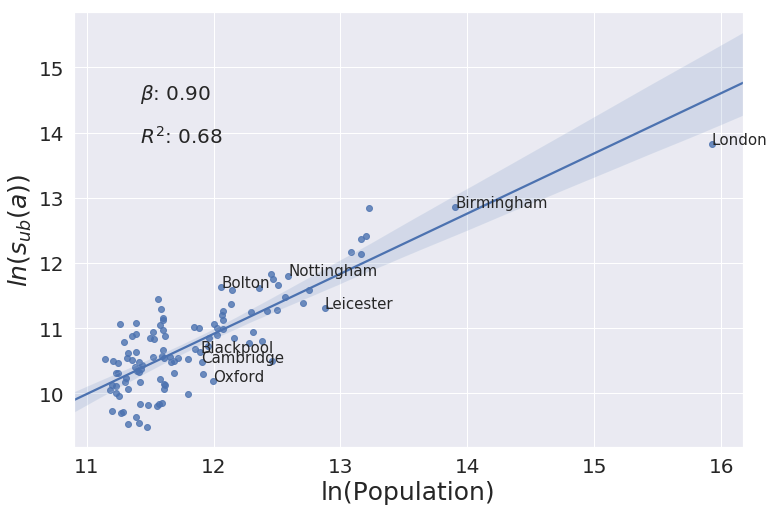

In [283]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
p = sns.regplot(x=predict,y=gt,ax=ax)
ax.set_xlabel("ln(Population)",fontsize=25)
ax.set_ylabel("$ln(s_{ub}(a))$",fontsize=25)
# ax.set_title("Opioids",fontsize=25)
plt.xticks(fontsize = 20 )
plt.yticks(fontsize = 20 )
label_point(predict , gt , names , ax)
ax.annotate(r"$\beta$" +": " +  str(slope)[:4], xy=(0.1, 0.8), xycoords='axes fraction',fontsize = 20)
# ax.annotate(r"$\alpha$" +": " +  str(intercept)[:4], xy=(0.1, 0.7), xycoords='axes fraction',fontsize = 20)
ax.annotate(r"$R^2$" +": " +  str(r_value**2)[:4], xy=(0.1, 0.7), xycoords='axes fraction',fontsize = 20)

Text(0.1,0.7,'$R^2$: 0.76')

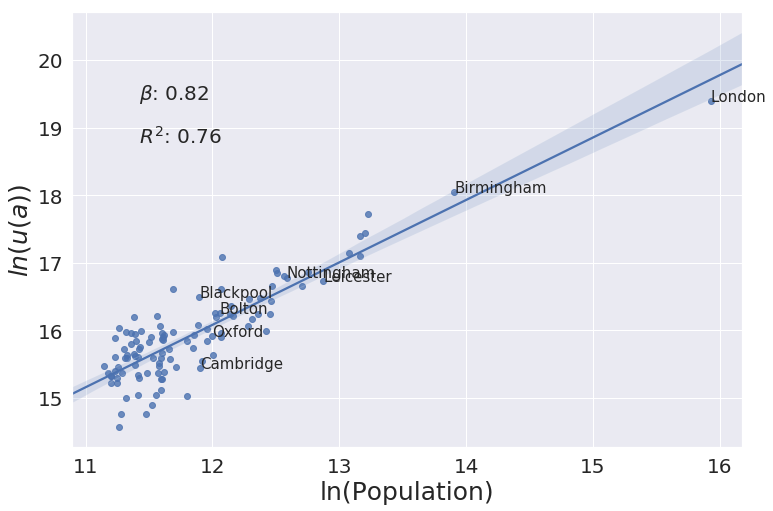

In [284]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
p = sns.regplot(x=predict_dosage,y=gt_dosage,ax=ax)
ax.set_xlabel("ln(Population)",fontsize=25)
ax.set_ylabel("$ln({u}(a))$",fontsize=25)
# ax.set_title("Opioids",fontsize=25)
plt.xticks(fontsize = 20 )
plt.yticks(fontsize = 20 )
label_point(predict_dosage , gt_dosage , names , ax)
ax.annotate(r"$\beta$" +": " +  str(slope_dosage)[:4], xy=(0.1, 0.8), xycoords='axes fraction',fontsize = 20)
# ax.annotate(r"$\alpha$" +": " +  str(intercept)[:4], xy=(0.1, 0.7), xycoords='axes fraction',fontsize = 20)
ax.annotate(r"$R^2$" +": " +  str(r_value_dosage**2)[:4], xy=(0.1, 0.7), xycoords='axes fraction',fontsize = 20)

In [279]:
cityOverSpending

{'Barnsley': 33946.86494201659,
 'Basildon': 42860.04966657336,
 'Basingstoke': 39215.81453414503,
 'Bath': 13165.018594300154,
 'Bedford': 13981.217837176622,
 'Birkenhead': 64667.48228491704,
 'Birmingham': 384864.15023360774,
 'Blackburn': 30348.923068980006,
 'Blackpool': 41436.17977108962,
 'Bolton': 112540.61233234737,
 'Bournemouth': 51256.71849031008,
 'Bracknell': 16669.81680576349,
 'Bradford': 107729.85099946582,
 'Brighton and Hove': 111445.92262706153,
 'Bristol': 245432.93058000138,
 'Burnley': 23466.715055159566,
 'Burton upon Trent': 16711.88864291643,
 'Bury': 29967.50735875734,
 'Cambridge': 35657.55415528078,
 'Carlisle': 30082.40487316827,
 'Chatham': 35026.73571589382,
 'Chelmsford': 53126.42031431634,
 'Cheltenham': 35815.31898636128,
 'Chester': 27717.621846041176,
 'Chesterfield': 31275.566686364982,
 'Colchester': 37680.85596170694,
 'Coventry': 87513.08308334333,
 'Crawley': 19102.775786800736,
 'Darlington': 26403.76538313558,
 'Derby': 36472.14713381999,
 'D

In [280]:
keys = ['opioids']
allCosts = {}
for k in keys:
    allCosts[k] = 0.0
    for m in monthly_borough_savings[k]:
        allCosts[k]+= np.sum(monthly_borough_savings[k][m].values())
    

In [281]:
sum(allCosts.values())

8160565.395357025

In [61]:
monthly_borough_costs_slice = monthly_borough_costs['opioids']
monthly_borough_savings_slice = monthly_borough_savings['opioids']
monthly_borough_dosage_slice = monthly_borough_dosage['opioids']

In [307]:
total_monthly_costs = {}
for k in monthly_borough_costs_slice:
    total_monthly_costs[k] = {}
    for b in monthly_borough_costs_slice[k]:
        scale = float( population_borough[b])/1000.0
        total_monthly_costs[k][b] = monthly_borough_costs_slice[k][b]*scale
        
total_monthly_costs

{'201008': {'Adur': 20692.05899047272,
  'Allerdale': 30624.483359801183,
  'Amber Valley': 42666.59914223313,
  'Arun': 58113.36770124906,
  'Ashfield': 51559.06314746118,
  'Ashford': 45799.76631865791,
  'Aylesbury Vale': 46245.529689844945,
  'Babergh': 44737.05641038557,
  'Barking and Dagenham': 41201.910001280085,
  'Barnet': 70209.53266747456,
  'Barnsley': 124614.80819538381,
  'Barrow-in-Furness': 40723.61075232473,
  'Basildon': 54661.66566600407,
  'Basingstoke and Deane': 47918.02412057766,
  'Bassetlaw': 51502.391214017756,
  'Bath and North East Somerset': 51786.38479049754,
  'Bedford': 43549.41760330173,
  'Bexley': 62168.4361741153,
  'Birmingham': 298937.1565605177,
  'Blaby': 29992.86882009902,
  'Blackburn with Darwen': 82261.51646168059,
  'Blackpool': 81026.14578244922,
  'Bolsover': 38198.54505319316,
  'Bolton': 140355.85541883053,
  'Boston': 35830.28168135126,
  'Bournemouth': 46012.805754768604,
  'Bracknell Forest': 23226.491326657495,
  'Bradford': 241335.

In [308]:
totalCost = {}
totalOverspend = {}
for k in monthly_borough_savings_slice:
    totalOverspend[k] = np.sum(monthly_borough_savings_slice[k].values())
    totalCost[k] = np.sum(total_monthly_costs[k].values())

In [309]:
np.sum(totalCost.values()) , np.sum(totalOverspend.values())

(2363830193.4802012, 140774523.61278066)

In [310]:
UKwide_opioid = {}
UKUKwide_opioid_costs = {}
for k in monthly_borough_savings_slice:
    UKwide_opioid[k] = sum(monthly_borough_savings_slice[k].values())
for k in monthly_borough_costs_slice:
    total = []
    for b in monthly_borough_costs_slice[k]:
        scale = float( population_borough[b])/1000.0
        total.append(monthly_borough_costs_slice[k][b]*scale)
    UKUKwide_opioid_costs[k] = total

In [311]:
all_overspend = {}
all_overspend['savings'] = totalOverspend
all_overspend['costs'] = totalCost

In [312]:
# all_overspend

In [313]:
# %store opioid_overspend
# %store all_overSpend

In [314]:
# all_monthly_borough_savings = monthly_borough_savings

# %store all_monthly_borough_savings
# %store -r monthly_borough_savings

In [315]:
# %store -r monthly_borough_savings

In [39]:
IMD_District = json.load(open('District_IMD_scores_life_values.json','rb'))

In [43]:
IMD_District['Wirral']

{u'District Code': [u'E08000015'],
 u'IMD': {u'mean_values': {u'Barriers to Housing and Services Score': 11.092393203883496,
   u'Crime Score': -0.2575485436893204,
   u'Education, Skills and Training Score': 19.966334951456307,
   u'Employment Score (rate)': 0.16867961165048542,
   u'Health Deprivation and Disability Score': 0.811742718446602,
   u'Income Score (rate)': 0.18586893203883495,
   u'Living Environment Score': 21.550587378640778},
  u'median_values': {u'Barriers to Housing and Services Score': 10.285,
   u'Crime Score': -0.3345,
   u'Education, Skills and Training Score': 12.633000000000001,
   u'Employment Score (rate)': 0.1315,
   u'Health Deprivation and Disability Score': 0.6655,
   u'Income Score (rate)': 0.144,
   u'Living Environment Score': 18.969}},
 u'Life Values': {u'Anxiety': 20.23,
  u'Happiness': 37.99,
  u'Life Satisfaction': 8.23,
  u'Worthwhile': 31.46},
 u'aggregate_IMD': 26.892,
 u'pop_density': 2033.765777476966,
 u'population': 320229,
 u'senior_pop': 

In [318]:
savings = {}
for month in monthly_borough_savings_slice:
    for dist in monthly_borough_savings_slice[month]:
        if dist not in savings:
            savings[dist] = 0.0
        else:
            savings[dist]+=monthly_borough_savings_slice[month][dist]
dose = {}
for month in monthly_borough_dosage_slice:
    for dist in monthly_borough_dosage_slice[month]:
        if dist not in dose:
            dose[dist] = 0.0
        else:
            dose[dist]+=monthly_borough_dosage_slice[month][dist]

cost = {}
for month in total_monthly_costs:
    for dist in total_monthly_costs[month]:
        if dist not in cost:
            cost[dist] = 0.0
        else:
            cost[dist]+=total_monthly_costs[month][dist]

            
dict_saving = {'Name':[],'Savings':[] , 'Dosage':[] , 'Density' : [] , 'Seniors' : [] , 'IMD' : [] , 'TotalCost':[]}
for s in savings:
    dict_saving['Name'].append(s)
    dict_saving['Savings'].append(savings[s])
    dict_saving['TotalCost'].append(cost[s])
    dict_saving['Dosage'].append(dose[s])
    dict_saving['Density'].append(IMD_District[s]['pop_density'])
    dict_saving['Seniors'].append(IMD_District[s]['senior_pop'])
    dict_saving['IMD'].append(IMD_District[s]['aggregate_IMD'])



savings_df = pd.DataFrame(dict_saving)

In [319]:
savings_df

,Density,Dosage,IMD,Name,Savings,Seniors,TotalCost
0,148.343861,9.890511e+05,17.204,Mendip,3.969829e+05,0.273837,4.222450e+06
1,731.965927,5.281658e+05,8.857,Windsor and Maidenhead,1.641956e+05,0.228971,3.702094e+06
2,501.819129,1.253594e+06,22.066,Wyre Forest,4.237294e+05,0.294166,4.125525e+06
3,540.901368,5.489963e+05,27.659,Peterborough,4.273101e+05,0.188738,5.478149e+06
4,372.224833,4.853350e+05,15.263,Epping Forest,2.547385e+05,0.249024,4.788984e+06
5,68.324381,1.132643e+06,12.670,Hambleton,3.515520e+05,0.299099,4.966958e+06
6,316.362046,5.149004e+05,11.648,Sevenoaks,3.678826e+05,0.262826,4.827500e+06
7,148.038665,1.041188e+06,16.991,Forest of Dean,2.927603e+05,0.291390,4.034341e+06
8,957.794920,1.097495e+06,12.547,Christchurch,8.538322e+04,0.376227,1.803155e+06
9,3217.686574,9.965943e+05,22.958,Dudley,7.133544e+05,0.252209,1.335995e+07


In [320]:
england = gp.read_file('../BL_Work/Local_Authority_Districts_December_2017_Ultra_Generalised_Clipped_Boundaries_in_United_Kingdom_WGS84.shp')

In [321]:
england.head()

,objectid,lad17cd,lad17nm,lad17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,E06000001,Hartlepool,None,447157,531476,-1.27023,54.676159,9.658682e+07,50245.931523,POLYGON ((-1.243847684350774 54.72307842291248...
1,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.544670,5.474167e+07,35458.505804,POLYGON ((-1.200218340036424 54.58300135026919...
2,3,E06000003,Redcar and Cleveland,None,464359,519597,-1.00611,54.567520,2.471405e+08,78666.802657,(POLYGON ((-1.200218311029187 54.5830013303063...
3,4,E06000004,Stockton-on-Tees,None,444937,518183,-1.30669,54.556911,2.064738e+08,86947.340766,POLYGON ((-1.193937249483723 54.62987548771687...
4,5,E06000005,Darlington,None,428029,515649,-1.56835,54.535351,1.982990e+08,91341.118700,POLYGON ((-1.439939711064031 54.59520822980085...


In [322]:
merged = england.set_index('lad17nm').join(savings_df.set_index('Name'))
merged = merged[np.isfinite(merged['Savings'])]

In [323]:
merged

,objectid,lad17cd,lad17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry,Density,Dosage,IMD,Savings,Seniors,TotalCost
lad17nm,,,,,,,,,,,,,,,,
Hartlepool,1,E06000001,None,447157,531476,-1.270230,54.676159,9.658682e+07,50245.931523,POLYGON ((-1.243847684350774 54.72307842291248...,954.975046,2.288297e+06,33.178,3.161153e+05,0.236996,7.252200e+06
Middlesbrough,2,E06000002,None,451141,516887,-1.210990,54.544670,5.474167e+07,35458.505804,POLYGON ((-1.200218340036424 54.58300135026919...,2534.522698,2.589949e+06,40.216,5.614741e+05,0.205897,1.359218e+07
Redcar and Cleveland,3,E06000003,None,464359,519597,-1.006110,54.567520,2.471405e+08,78666.802657,(POLYGON ((-1.200218311029187 54.5830013303063...,546.239964,2.104544e+06,28.567,4.834330e+05,0.268515,9.742069e+06
Stockton-on-Tees,4,E06000004,None,444937,518183,-1.306690,54.556911,2.064738e+08,86947.340766,POLYGON ((-1.193937249483723 54.62987548771687...,927.265325,1.815695e+06,24.625,5.081257e+05,0.222208,1.343629e+07
Darlington,5,E06000005,None,428029,515649,-1.568350,54.535351,1.982990e+08,91341.118700,POLYGON ((-1.439939711064031 54.59520822980085...,530.754153,1.266896e+06,23.639,2.638561e+05,0.242703,7.339963e+06
Halton,6,E06000006,None,354246,382146,-2.688530,53.334240,8.097198e+07,59054.624290,(POLYGON ((-2.695154845015741 53.3846370930314...,1552.290033,1.391868e+06,31.943,3.332384e+05,0.221804,7.519917e+06
Warrington,7,E06000007,None,362744,388456,-2.561670,53.391628,1.805179e+08,71160.979991,POLYGON ((-2.491122301223966 53.46052933409025...,1121.212917,9.041193e+05,19.312,4.349302e+05,0.225263,9.771199e+06
Blackburn with Darwen,8,E06000008,None,369490,422806,-2.463600,53.700802,1.389175e+08,55608.031446,POLYGON ((-2.467231781284216 53.78102305145166...,1063.314455,1.211531e+06,34.189,3.723412e+05,0.185305,8.552493e+06
Blackpool,9,E06000009,None,332763,436633,-3.022840,53.821610,3.670436e+07,31400.593997,POLYGON ((-3.012012683936433 53.82639068184907...,3868.096727,1.646787e+06,41.997,3.908478e+05,0.258114,9.781994e+06


In [324]:
merged.to_csv('anti_dep_borough_2016_data.csv')

In [ ]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Savings'
vmin, vmax = min(savings_df['Savings']) , max(savings_df['Savings'])

fig, ax = plt.subplots(1, figsize=(18, 12))
merged.plot(column=variable, cmap='Reds', linewidth=1, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Overspending for opioids', fontdict={'fontsize': 25, 'fontweight' : 20})
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.yaxis.offsetText.set(size=20)
cbar.ax.tick_params(labelsize=30) 

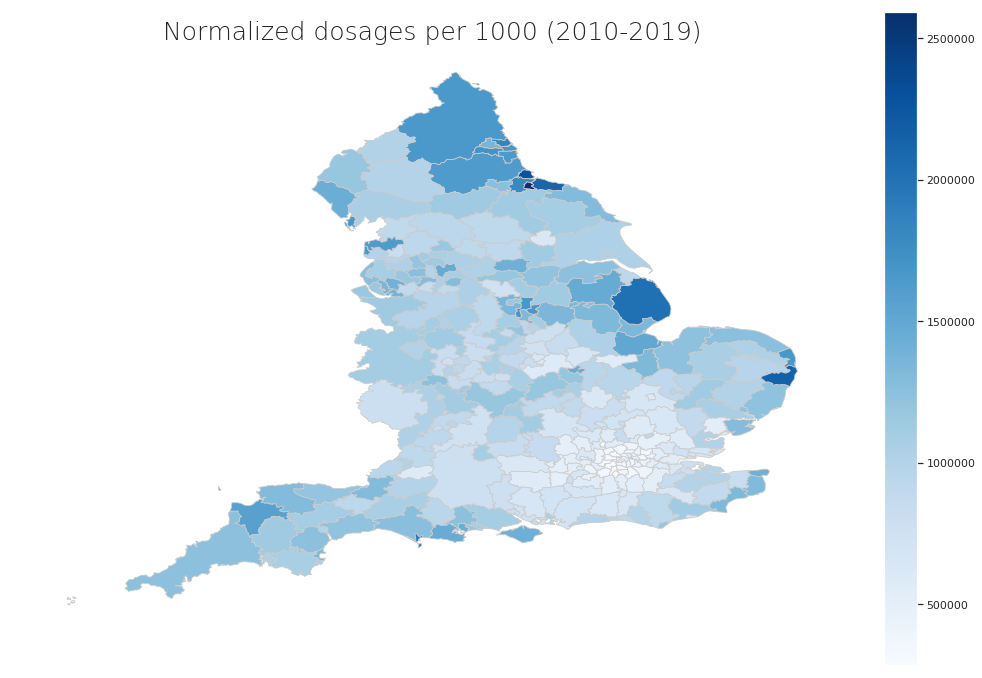

In [326]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Dosage'
vmin, vmax = min(savings_df['Dosage']) , max(savings_df['Dosage'])

fig, ax = plt.subplots(1, figsize=(18, 12))
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Normalized dosages per 1000 (2010-2019)', fontdict={'fontsize': 25, 'fontweight' : 5})
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

In [289]:
standardized_merged = merged.copy()

In [290]:
def normalize(df,feature_names):
    result = df.copy()
    for feature_name in feature_names:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [291]:
standardized_merged = normalize(merged , ['Savings','Density','Dosage','IMD','Seniors'])

In [292]:
standardized_merged.head()

,objectid,lad17cd,lad17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry,Density,Dosage,IMD,Savings,Seniors,TotalCost
lad17nm,,,,,,,,,,,,,,,,
Hartlepool,1,E06000001,None,447157,531476,-1.27023,54.676159,9.658682e+07,50245.931523,POLYGON ((-1.243847684350774 54.72307842291248...,0.067302,0.869047,0.761571,0.115447,0.502048,7.252200e+06
Middlesbrough,2,E06000002,None,451141,516887,-1.21099,54.544670,5.474167e+07,35458.505804,POLYGON ((-1.200218340036424 54.58300135026919...,0.181541,1.000000,0.951849,0.205671,0.399775,1.359218e+07
Redcar and Cleveland,3,E06000003,None,464359,519597,-1.00611,54.567520,2.471405e+08,78666.802657,(POLYGON ((-1.200218311029187 54.5830013303063...,0.037741,0.789277,0.636909,0.176974,0.605706,9.742069e+06
Stockton-on-Tees,4,E06000004,None,444937,518183,-1.30669,54.556911,2.064738e+08,86947.340766,POLYGON ((-1.193937249483723 54.62987548771687...,0.065298,0.663882,0.530334,0.186054,0.453415,1.343629e+07
Darlington,5,E06000005,None,428029,515649,-1.56835,54.535351,1.982990e+08,91341.118700,POLYGON ((-1.439939711064031 54.59520822980085...,0.036621,0.425639,0.503677,0.096231,0.520818,7.339963e+06


In [293]:
corr = pearsonr(standardized_merged['Dosage'], standardized_merged['IMD'])

Text(0.8,0.2,'Corr: 0.35')

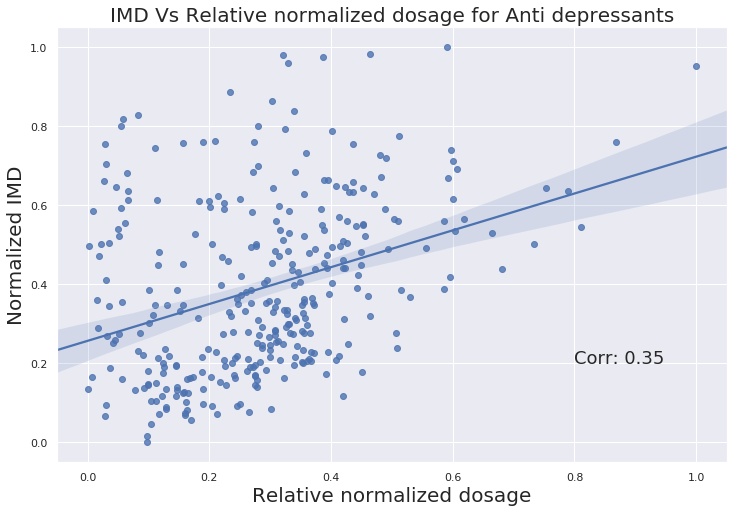

In [294]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.regplot(x='Dosage',y='IMD',data=standardized_merged)
ax.set_title("IMD Vs Relative normalized dosage for Anti depressants" , fontsize=20)
ax.set_xlabel("Relative normalized dosage",fontsize=20)
ax.set_ylabel("Normalized IMD",fontsize=20)
ax.annotate("Corr: " +  str(corr[0])[:4],  xy=(0.8, 0.2),fontsize = 18)


In [295]:
corr = pearsonr(standardized_merged['Savings'], standardized_merged['IMD'])

Text(0.8,0.2,'Corr: 0.29')

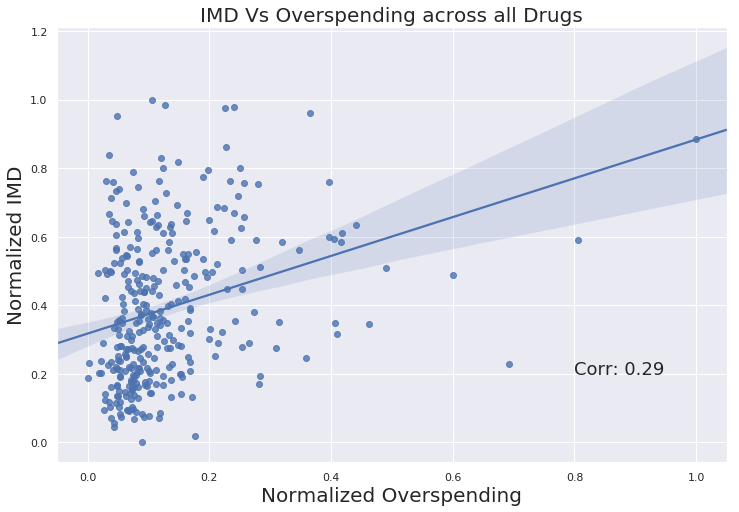

In [139]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.regplot(x='Savings',y='IMD',data=standardized_merged)
ax.set_title("IMD Vs Overspending across all Drugs" , fontsize=20)
ax.set_xlabel("Normalized Overspending",fontsize=20)
ax.set_ylabel("Normalized IMD",fontsize=20)
ax.annotate("Corr: " +  str(corr[0])[:4],  xy=(0.8, 0.2),fontsize = 18)


In [140]:
corr = pearsonr(standardized_merged['Savings'], standardized_merged['Seniors'])

Text(0.8,0.2,'Corr: -0.1')

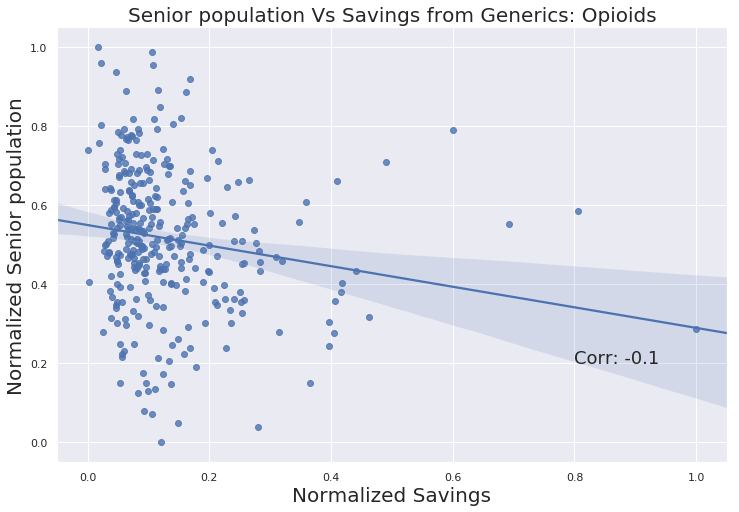

In [141]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.regplot(x='Savings',y='Seniors',data=standardized_merged)
ax.set_title("Senior population Vs Savings from Generics: Opioids" , fontsize=20)
ax.set_xlabel("Normalized Savings",fontsize=20)
ax.set_ylabel("Normalized Senior population",fontsize=20)
ax.annotate("Corr: " +  str(corr[0])[:4],  xy=(0.8, 0.2),fontsize = 18)

In [142]:
corr=pearsonr(standardized_merged['Savings'], standardized_merged['Density'])

Text(0.8,0.8,'Corr: 0.08')

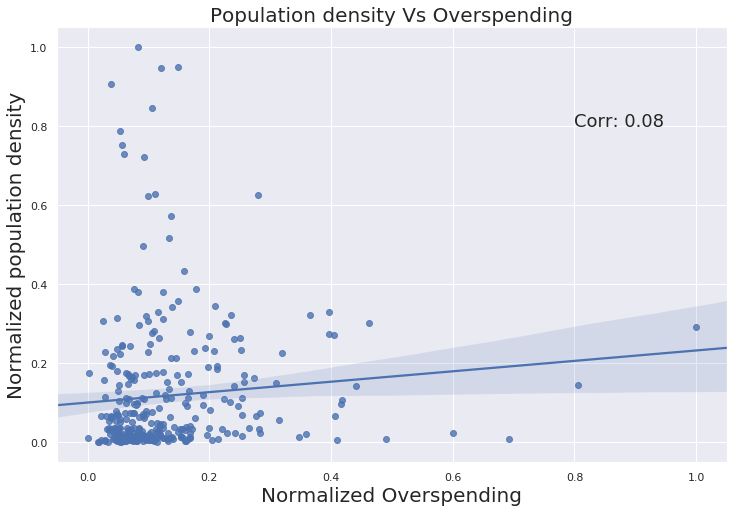

In [143]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.regplot(x='Savings',y='Density',data=standardized_merged)
ax.set_title("Population density Vs Overspending" ,fontsize=20)
ax.set_xlabel("Normalized Overspending",fontsize=20)
ax.set_ylabel("Normalized population density",fontsize=20)
ax.annotate("Corr: " +  str(corr[0])[:4],  xy=(0.8, 0.8),fontsize = 18)

In [144]:
corr=pearsonr(standardized_merged['Dosage'], standardized_merged['Density'])

Text(0.8,0.8,'Corr: -0.0')

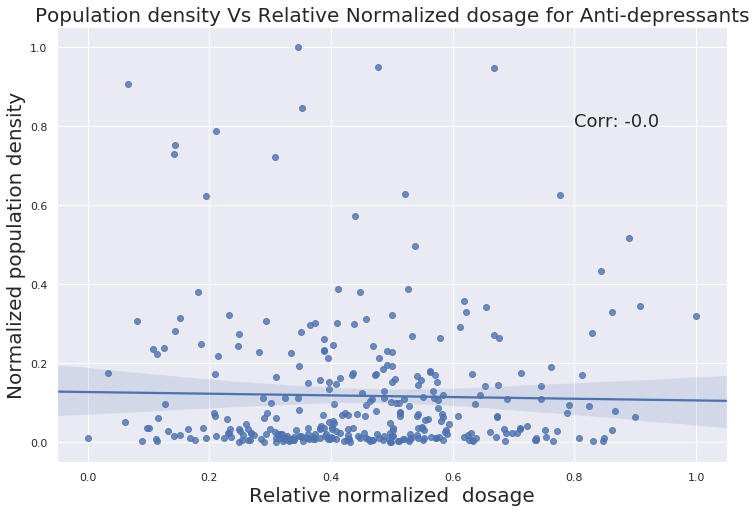

In [145]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.regplot(x='Dosage',y='Density',data=standardized_merged)
ax.set_title("Population density Vs Relative Normalized dosage for Anti-depressants" ,fontsize=20)
ax.set_xlabel("Relative normalized  dosage",fontsize=20)
ax.set_ylabel("Normalized population density",fontsize=20)
ax.annotate("Corr: " +  str(corr[0])[:4],  xy=(0.8, 0.8),fontsize = 18)


In [146]:
pearsonr(standardized_merged['Dosage'], standardized_merged['Seniors'])

(0.05405512699586862, 0.33057649643860887)

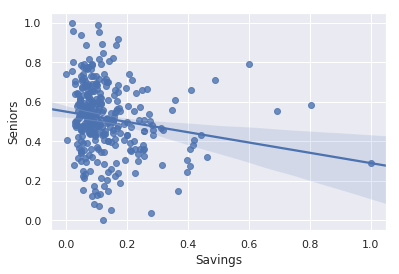

In [147]:
sns.regplot(x='Savings',y='Seniors',data=standardized_merged)

In [148]:
monthlySavings = {}
for k in monthly_borough_savings:
    monthlySavings[k] = np.median(monthly_borough_savings[k].values())
    
    
monthlyCosts = {}
for k in monthly_borough_costs:
    monthlyCosts[k] = np.median(monthly_borough_costs[k].values())

/home/sagar/anaconda3/envs/env_py2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sagar/anaconda3/envs/env_py2/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/sagar/anaconda3/envs/env_py2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/sagar/anaconda3/envs/env_py2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/home/sagar/anaconda3/envs/env_py2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/home/sagar/anaconda3/envs/env_py2/lib/python2.7/inspect.py", line 1058, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/home/sagar/anaconda3/envs/env_py2/lib/python2.7/inspect.py", line 1018, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/home/sagar/anaconda3/envs/env_py2/lib/python2.7/inspect.py", line 453, in getsour

IndexError: string index out of range

In [119]:
months = sorted(all_overspend['savings'].keys())

In [120]:
overspend = [all_overspend['savings'][k]/1000000.0 for k in months]

Text(0,0.5,'Overspending in Million Sterling pounds')

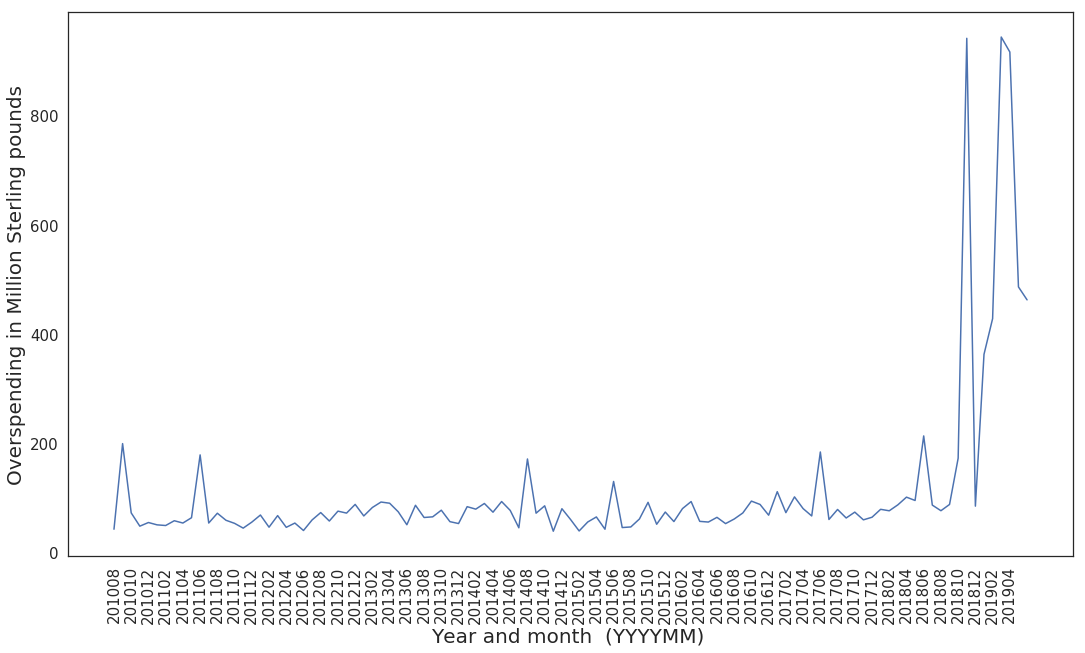

In [140]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
sns.set_style("white")
sns.lineplot(y=overspend,x=np.arange(0,len(months),1))
# sns.lineplot(y=savings_df['diabetes_over'],x=np.arange(0,len(savings_df),1))
# sns.lineplot(y=savings_df['opioid_over'],x=np.arange(0,len(savings_df),1))
ax = plt.gca()

# plt.xticks(np.arange(0,len(months)+1, 2.0))
labels= [months[2*i] for i in range(0,len(months)/2)]
plt.xticks(np.arange(0,len(months) ,2),labels,rotation=90,fontsize= 15)
plt.yticks(fontsize= 15)
# plt.legend(['Overspending for Depression', 'Overspending for Diabetes', 'Overspending for Opioids'], fontsize = 16)
plt.xlabel("Year and month  (YYYYMM) ",fontsize=20)
plt.ylabel("Overspending in Million Sterling pounds",fontsize=20)
